## Surface and uncertainty maps from final predictions

In [9]:
import os
import functions
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import rasterio

from rasterio.features import shapes
from shapely.geometry import shape, mapping

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Parameters

In [10]:
#Load report
with open('temp_files/report/report.pkl', 'rb') as pickle_file:
    report = pickle.load(pickle_file)

In [11]:
country = report['Country']
year = report['DHS survey year']
#target_indicator = report['Target Indicator']
target_indicator = report['Target Indicator']

### Load files

In [12]:
# Load the shape file with geographic covariates
shape_path = os.path.join('temp_files/clipped_shape/clipped_shape.shp')
gdf = gpd.read_file(shape_path)

In [13]:
gdf = gdf[['grid_id', 'geometry']]

In [14]:
#Load report
with open('temp_files/predictions_final.pkl', 'rb') as pickle_file:
    df = pickle.load(pickle_file)

In [15]:
gdf = gdf.merge(df[['grid_id', target_indicator, 'absolute_confidence_interval',
       'standardized_uncertainty']], how='left', on='grid_id')

### Uncertainty maps

Generate maps of prediction uncertainty to visualize areas of high and low certainty in the predictions.

### Surface maps

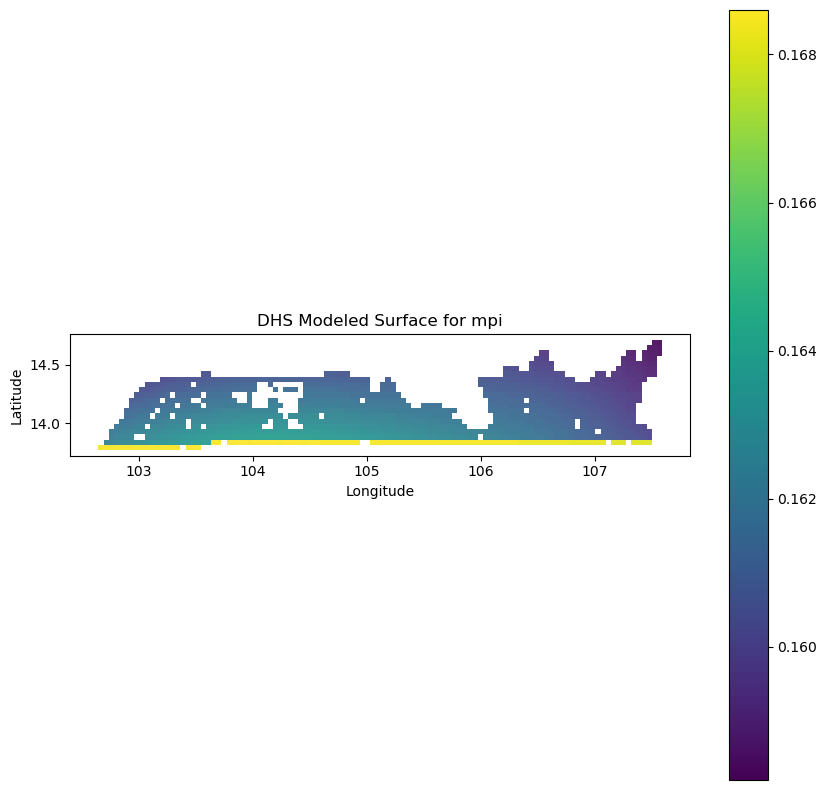

In [16]:
import matplotlib.pyplot as plt
import os

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with a colormap based on the target_indicator
gdf.plot(ax=ax, column=target_indicator, cmap='viridis', alpha=0.8)

# Customize the plot (optional)
ax.set_title(f'DHS Modeled Surface for {target_indicator}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

gdf.plot(ax=ax, column=target_indicator, cmap='viridis', alpha=0.5, legend=True)

# Save the plot as a PDF
plt.savefig(os.path.join('temp_files/report', 
                         f'{country} - {year} -  {target_indicator} Predictions.pdf'))

plt.show()

<Axes: >

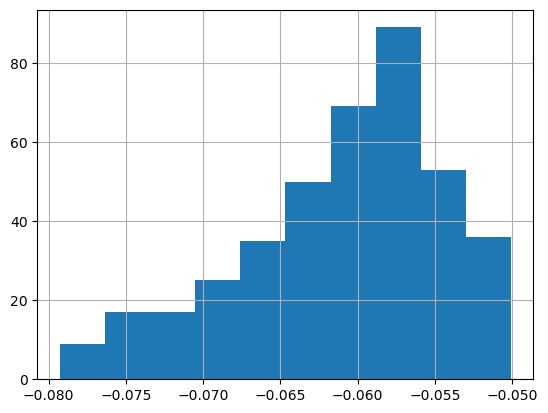

In [12]:
df['mpi_untransformed'].hist()

<Axes: >

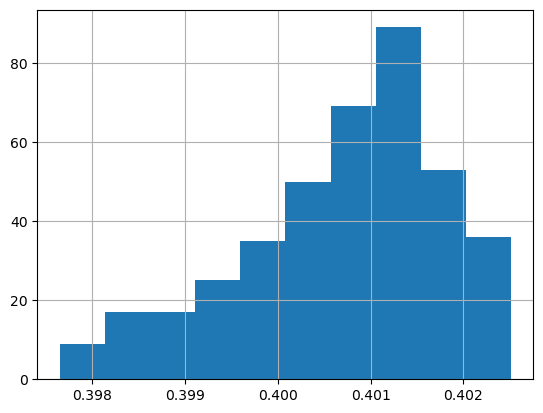

In [13]:
df['mpi_denormalized'].hist()

<Axes: >

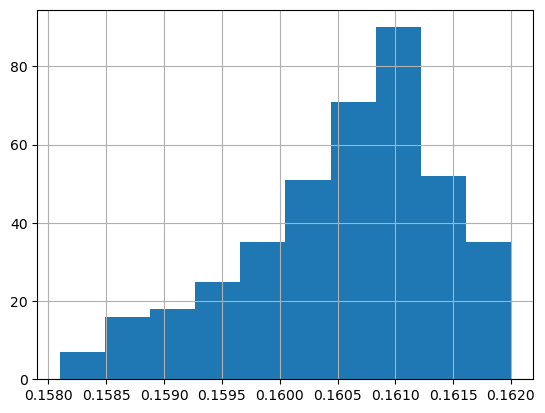

In [15]:
df['mpi'].hist()

In [16]:
report['Transformation Applied']

'sqrt'